Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [52]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers,models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

In [53]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [54]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [55]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [56]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [57]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    color_mode='rgb',
    subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [58]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    color_mode='rgb',
    subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [59]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

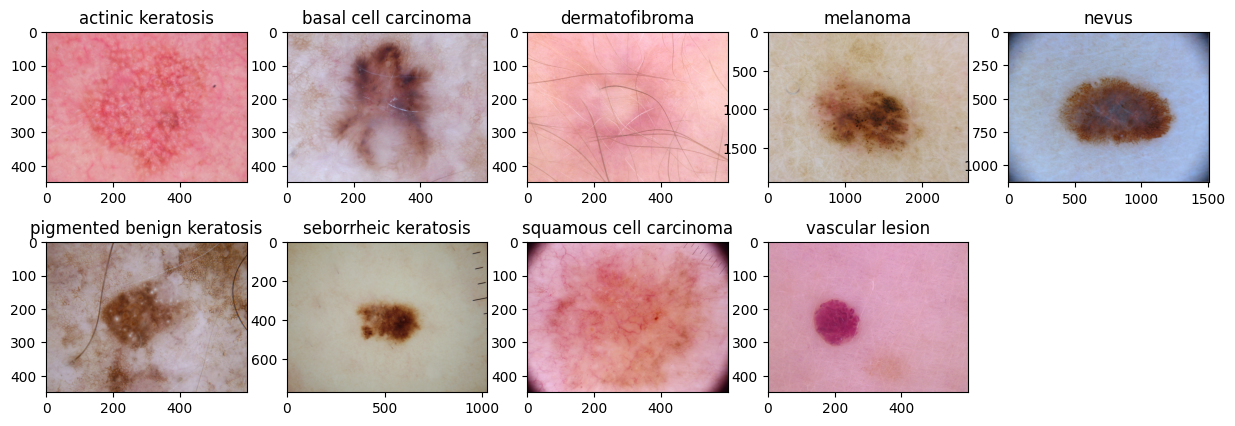

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [62]:
# model architecture
model = Sequential()
model.add(layers.Rescaling(
    1./255, offset=0.0, input_shape =(180,180,3)))
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [63]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [64]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 activation_16 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 activation_17 (Activation)  (None, 90, 90, 128)       0         
                                                      

### Train the model

In [65]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 123ms/step - loss: 3.5203 - accuracy: 0.1814 - val_loss: 2.0144 - val_accuracy: 0.1611
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9677 - accuracy: 0.2930 - val_loss: 1.8332 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 1.6920 - accuracy: 0.3945 - val_loss: 1.8827 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5637 - accuracy: 0.4453 - val_loss: 1.7503 - val_accuracy: 0.3445
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3865 - accuracy: 0.5156 - val_loss: 1.5291 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 4s 72ms/step - loss: 1.2672 - accuracy: 0.5525 - val_loss: 1.4696 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.0859 - accuracy: 0.6261 - val_loss: 1.6813 - val_accuracy: 0.4407
Epoch 8/20


### Visualizing training results

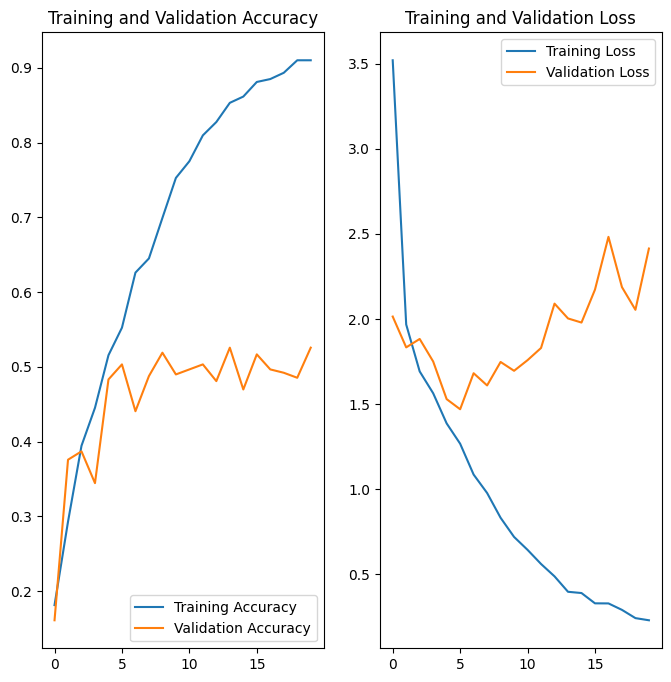

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings :
As the training accuracy increases linearly, where as the validation accuracy increases and stall at 51% accuracy in training process.

As the training loss decreases with epochs the validation loss increases and stalls.

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around 51% accuracy on the validation set

The difference in accuracy between training and validation accuracy is huge  which idicates model is overfitting.

In [67]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

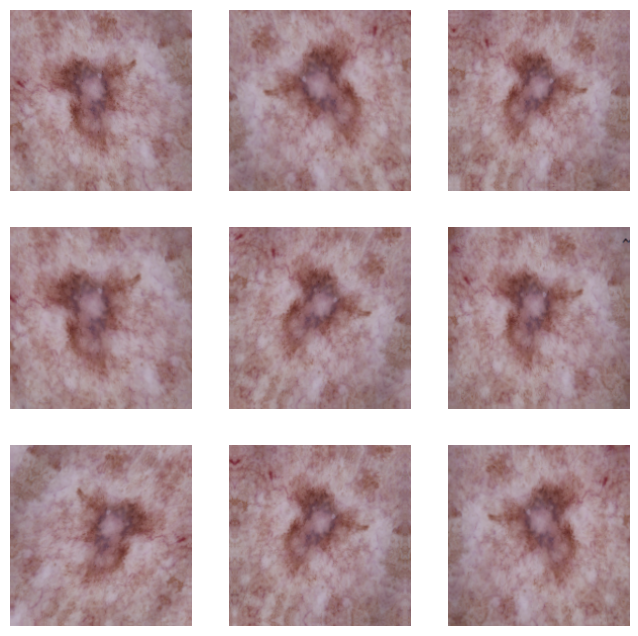

In [68]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Buiding the model after adding the Augmented layer

In [69]:
# model architecture
model = Sequential()
model.add(layers.Rescaling(
    1./255, offset=0.0, input_shape =(180,180,3)))
model.add(data_augmentation)

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))


In [70]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 activation_20 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 128)       73856     
                                                      

In [71]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 76ms/step - loss: 3.7899 - accuracy: 0.2254 - val_loss: 1.8453 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.7282 - accuracy: 0.3728 - val_loss: 1.6685 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 1.5664 - accuracy: 0.4481 - val_loss: 1.6221 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 1.5029 - accuracy: 0.4799 - val_loss: 1.5006 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 1.4018 - accuracy: 0.5056 - val_loss: 1.5559 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 4s 71ms/step - loss: 1.4446 - accuracy: 0.5011 - val_loss: 1.4281 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3384 - accuracy: 0.5329 - val_loss: 1.4425 - val_accuracy: 0.5123
Epoch 8/20
56

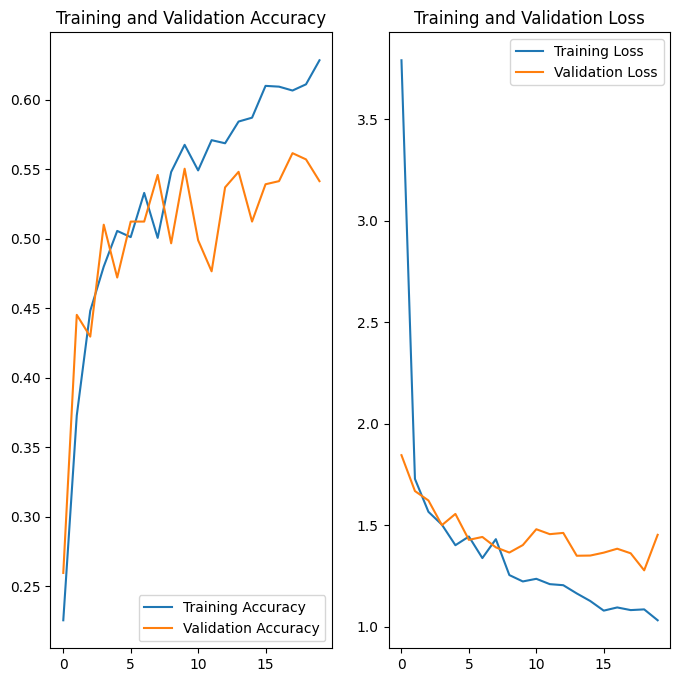

In [72]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo:
### adding dropout layer


In [73]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# model architecture
model = Sequential()
model.add(layers.Rescaling(
    1./255, offset=0.0, input_shape =(180,180,3)))
model.add(data_augmentation)

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))




### Compiling the model

In [74]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 activation_24 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 128)       73856     
                                                      

### Training the model

In [75]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 113ms/step - loss: 3.5314 - accuracy: 0.2801 - val_loss: 1.9694 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 1.8121 - accuracy: 0.3488 - val_loss: 1.6022 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 6s 110ms/step - loss: 1.5298 - accuracy: 0.4699 - val_loss: 1.4576 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 6s 111ms/step - loss: 1.5153 - accuracy: 0.4643 - val_loss: 1.4457 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 6s 113ms/step - loss: 1.4243 - accuracy: 0.4833 - val_loss: 1.4395 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 6s 110ms/step - loss: 1.3725 - accuracy: 0.5156 - val_loss: 1.4386 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 6s 111ms/step - loss: 1.3931 - accuracy: 0.4911 - val_loss: 1.4053 - val_accuracy: 0.5302
Epoch 

### Visualizing the results

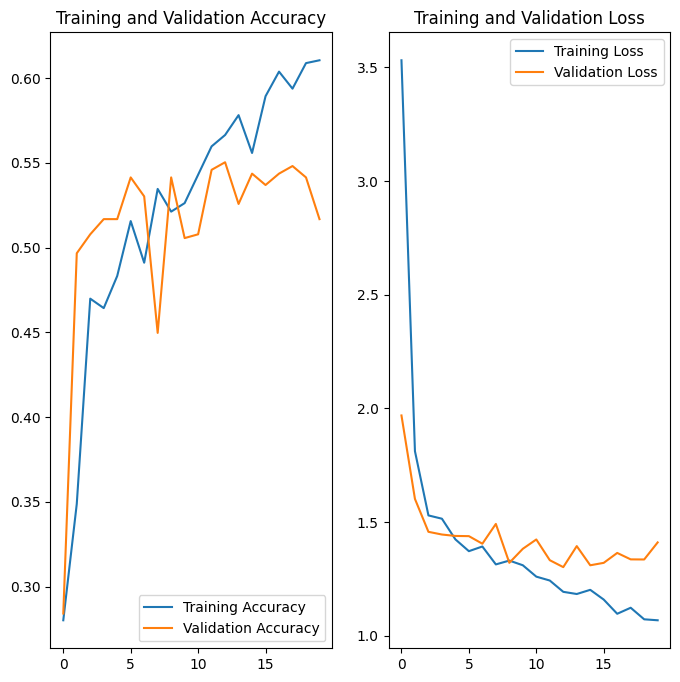

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings :
As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 51% accuracy in training process.

As the training loss decreases with epochs the validation loss decreases

The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 51% accuracy on the validation set.

The difference in accuracy between training and validation accuracy is very less

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [77]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


### Findings :
#### - Which class has the least number of samples?
#### seborrheic keratosis with 77 samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### pigmented benign keratosis with 462 samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [78]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [100]:
path_to_training_dataset=pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

TypeError: ignored

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
# model architecture
model = Sequential()
model.add(layers.Rescaling(
    1./255, offset=0.0, input_shape =(180,180,3)))

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

#### **Todo:**  Train your model

In [ ]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings :
As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.

As the training loss decreases with epochs the validation loss also decreases.

The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 75% accuracy on the validation set.

The difference in accuracy between training and validation accuracy is very less